In [80]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse 
import sys
from gaussiandata import SyntheticTarget
import math
import scipy

import matplotlib.pyplot as matlab
%matplotlib inline

In [93]:
SEED = 666
number_of_gaussians = 2
ex = SyntheticTarget(seed=SEED, dist_components=number_of_gaussians)

N = 10000
M = 200
data = ex.draw_sample(N)
gamma = 2
kernel_matrix = rbf_kernel(data, gamma = gamma)

In [94]:
# K is the kernel matrix which is nbyn, n being the number of data points
# candidate indicies is an array of 0 to n-1, you might want to use a subset instead. TO CONSIDER.

def greedy_select_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    value = np.array([])
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            if is_K_sparse:
                s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
            else:
                s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))

        argmax = candidates[np.argmax(s1array)]
        # print "max %f" %np.max(s1array)

        selected = np.append(selected, argmax)
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected]

In [95]:
#print np.array(range(np.shape(kernel_matrix)[0]))
#print np.array(range(N))
prototype_indices = greedy_select_protos(kernel_matrix, candidate_indices = np.array(range(N)), m = M)

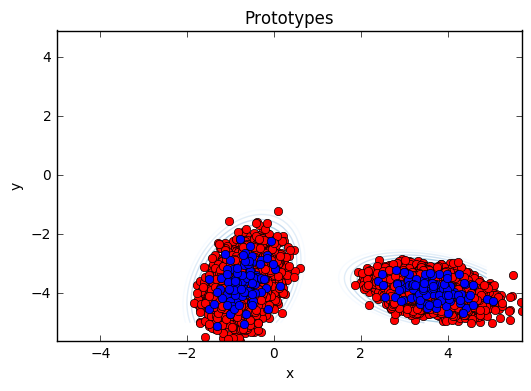

In [96]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Prototypes')

In [97]:
##############################################################################################################################
# function to select criticisms
# K is the kernel matrix which is nbyn, n being the number of data points
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
##############################################################################################################################
def greedy_select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=False):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print "wrong regularizer :" + regularizer
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected


In [98]:
#included argument is_K_sparse = False since otherwise todense function is not recognized. CHECK.
criticism_indices = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = M,  reg = 'None', is_K_sparse=False)

#K_sparse = sparse.csr_matrix(kernel_matrix)
#criticism_indices_sparse = greedy_select_criticism_regularized(K_sparse, selectedprotos = prototype_indices, m = M/4,  is_K_sparse=True)

In [99]:
print criticism_indices

[8893 7891 3611 7240 1125 7432 9523 9447 4663  982 1237 1344 3791 7070 3723
 1870 2096  395 1016 1120 5182 1058 4890 4770 7275 8467  301 5693 5249 7575
 6617 1337 6961 2792 5151 7603 4594 3352 2802 1363 7271 1989 3665 8468  302
 8245 9450 4898 3152 6919 1834 5025 1577 3227 8657 1324 3043  238 4752 2170
 6985 1097 1854 4102  349 9642 8897 5088 3045 9158 9657 6260 1805 3091 4861
 9747 1909 2945 1538 3797 9526 7513 9795 9851 1470 6293 2752 9700  961  872
 1475 3454 1684 9137 7000 2834 7162 8344 8953 5969 6378 4757 9032 2805 8773
 6317 9291 5611 6367  164 8954 1044 5800 6944  981 4830 8621 5955 6860 8395
  506 7477 9374 4989 2310  502 6062 9175 4907 1808  934  242 1910 1897 1939
 2498 5049 8928 5913 9075 3228 9388  832 4424 6232 6907 1710 5251 8898 1493
 3186 7544 3368 4179 8435 5986 4027 5645 5978 6932  433  805 4386  384 7955
 2731 7082 9150 1830 3385 4967 3907 2790 1828 1172 8791 4526 5102 9210  880
 9680 9941  704 1714 3536 3603  885 2104 8579 4361 6823 8137 5718 6380 4214
 6926 8688 1

[-6, 6, -6, 2]

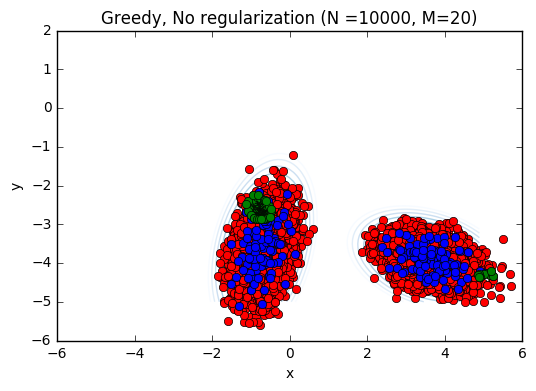

In [100]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.plot(data[criticism_indices,0], data[criticism_indices,1], 'go');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Greedy, No regularization (N =10000, M=20)')
matlab.axis([-6, 6, -6, 2])

In [101]:
criticism_indices2 = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = 20,  reg = 'logdet', is_K_sparse=False)

In [102]:
print prototype_indices

[5520 9233 8410 2765 5408 7700 6251 3124 3154 8664 3021 7174 4807 5573 6757
 2866 2509 3216 2984 9589 4789 9973 3970 8961 8676  273 6175 7566  422 9159
  890 5999 4149 5382 2271 8973 6197 9490 9316 4673  462 1366 6309 5096 6603
 6621 1770 1135 1426 9524 8569 5369 2886 6060 8788 5336 2350 9297 7198 2719
 8580 4556 4271 8952 9421 9819 1784 5344 4875 6594 1699 4037 7725 9828 3376
 6622 8567 4374 8793 4737 5005 9767 1547 5781 1349 2911  134 7105 2623 3882
 8532 8728 1281 9468 8541  666 8165 2594 2686 3963  882 4959 9093 6496 7994
 4488 5963 3419 2405 1287 4313 8739 4431 3036 3342 1086 4818 9600 1453    5
 8158 9057 4918 8456 4553   87 2742 4300 3203 5925 8963 9301 1358 9051 1170
 1089 4669 9870 7375 3728 2091  495 1407 4528 5630 2521 8792 1533   40 2869
 5689 8423 3493 8984 2803 9165  508 6616  144  822 1976 9217  633 1164 6855
 4056 2830 7926 5744 4232 8841 4748 3554  896  714 2665 8369 5794 9836 4258
  286 8960 6871 1300 3199 7792 5599 5877 4822 8293 6783 2930 3538 9534  481
 5619 7999 3

[-3, 6, -6, 0]

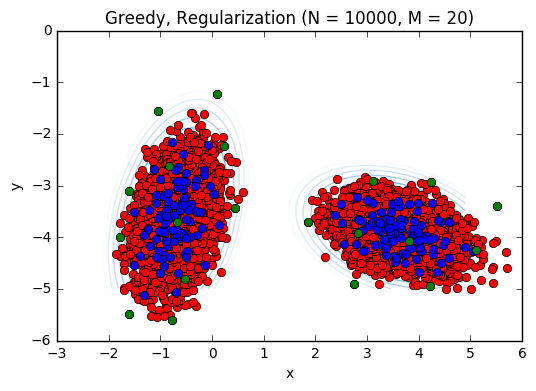

In [103]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.plot(data[criticism_indices2,0], data[criticism_indices2,1], 'go');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Greedy, Regularization (N = 10000, M = 20)')
matlab.axis([-3, 6, -6, 0])

In [104]:
# Change for different sampled target dist
SEED = 666
ex = SyntheticTarget(seed=SEED, dist_components=2)
N = 1000
M = 10
stream = ex.draw_sample(N)
#stream.shape finds the dimensions of the nparray stream
print stream.shape, "=>", M

(1000, 2) => 10
